# Project4 - Deep Lerning

## Image Classification


---
## 데이터 설명 - Stanford Cars Dataset (1.85 GB)

http://ai.stanford.edu/~jkrause/cars/car_dataset.html

196 class의 (차종)

8,144 개의 train 이미지 

8,041 개의 test 이미지

총 16,185 개의 이미지로 구성


* 

주어진 데이터는 바운딩 박스의 좌표 데이터도 함께 주어졌다. 따라서 전처리로 선행되어야 할 바운딩 처리는 생략하고 진행한다.

---

##Data set 정보
- train.csv - Train 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
- test.csv - Test 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
- class.csv - 데이터 셋의 class 컬럼과 대응되는 차종의 레이블
- train - Train 이미지 파일
- test - Test 이미지 파일

---

## 목표 

1. 이미지에서 자동차 인식

2. 구분된 자동차의 차종 분류 예측  
   (test 의 class 가 target이 된다.)

---


In [210]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [174]:
## 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### 파일 로드 및 확인

In [181]:
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Stanford Cars Dataset/car_data/car_data/'
os.listdir(DATA_PATH)

['train.csv', 'test', 'class.csv', 'test.csv', 'train']

In [182]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

In [185]:
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


In [186]:
df_test.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,00001.jpg,30,52,246,147
1,00002.jpg,100,19,576,203
2,00003.jpg,51,105,968,659
3,00004.jpg,67,84,581,407
4,00005.jpg,140,151,593,339


In [187]:
df_class.head()

,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012


In [188]:
df_class[df_class['id'] == 32]

,id,name
31,32,BMW X5 SUV 2007


In [204]:
# Data 누락 체크
if set(list(df_train.img_file)) == set(os.listdir(TRAIN_IMG_PATH)) :
    print("Train file 누락 없음!")
else : 
    print("Train file 누락")

if set(list(df_test.img_file)) == set(os.listdir(TEST_IMG_PATH)) :
    print("Test file 누락 없음!")
else : 
    print("Test file 누락")

Train file 누락
Test file 누락 없음!


## 파일 실제 확인

In [218]:
## 파일 총 길이 체크 (test = 8041)
len(os.listdir(TEST_IMG_PATH))

8041

In [217]:
## 파일 총 길이 체크 (train = 8144)
len(os.listdir(TRAIN_IMG_PATH))

8144

In [219]:
## class 종류 
len(df_class)

196

In [220]:
## train 파일의 class 종류 
df_train['class'].nunique()

196

In [ ]:
## 파일 업로드 오류 찾기 (test)
a1 = os.listdir(TEST_IMG_PATH)

for i in range(0,8100):
    a1.sort()
    if int(a1[i][0:5]) == i+1:
        pass
    else:
        print(i,int(a1[i][0:5]),'Flas')
        break

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


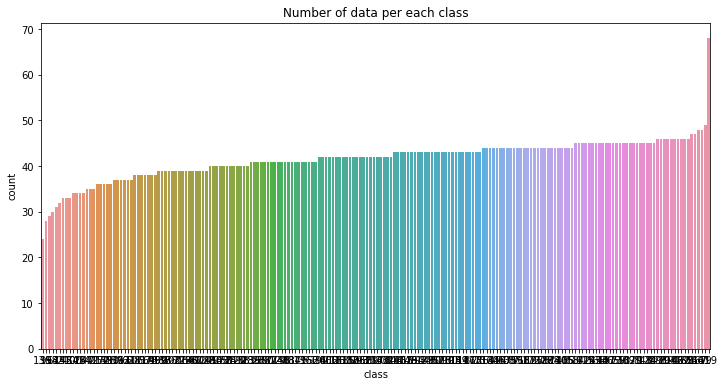

In [211]:
## 클래스 분포 확인

plt.figure(figsize=(12, 6))
sns.countplot(df_train["class"], order=df_train["class"].value_counts(ascending=True).index)
plt.title("Number of data per each class")
plt.show()

## 이미지 확인

In [216]:
import PIL
from PIL import ImageDraw

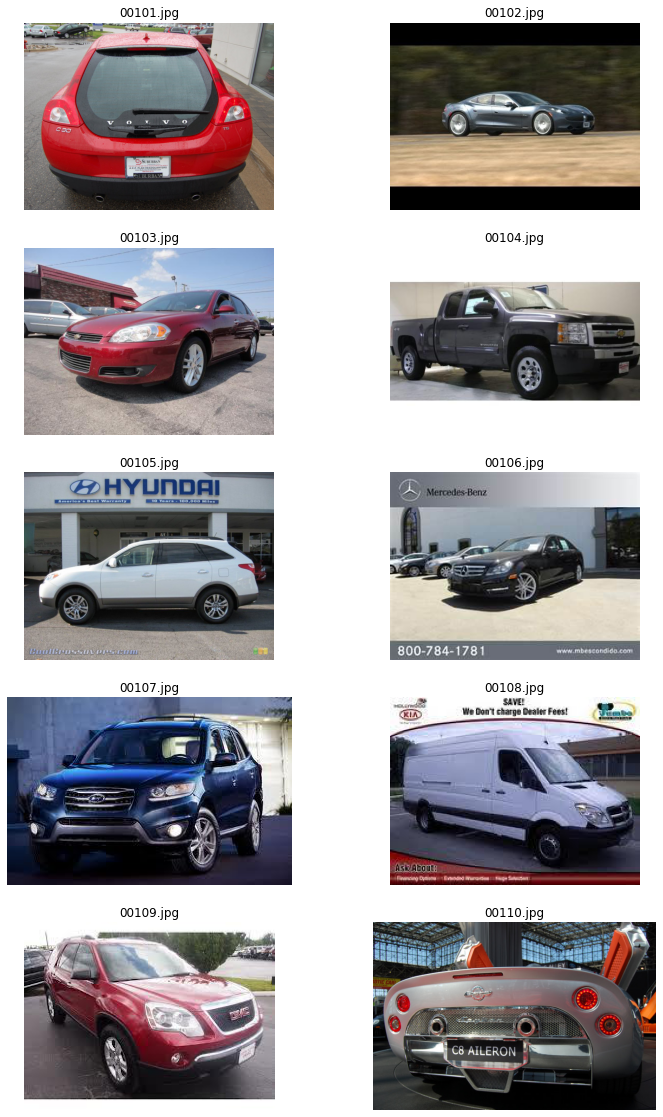

In [221]:
tmp_imgs = df_train['img_file'][100:110]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    plt.subplot(5, 2, num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')